In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
# from pmdarima.arima.utils import ndiffs
# from pmdarima.arima import auto_arima
# from pmdarima.arima import ADFTest
# from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import display, Markdown
from IPython.display import Math
import datetime
import math
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ValueError)

In [14]:
df = pd.read_csv('G:/My Drive/eo_context.csv', parse_dates=['DATE'])
df = df.drop(columns=['b_competitive_S', 'b_competitive_I'])
df_spend = df.drop(columns=['display_I', 'b_branded_I', 'b_category_I', 'p_auto_I',
                            'p_auto_comp_I', 'p_brand_I', 'p_category_I', 'p_competitive_I'])
df_context =  df_spend.drop(columns=['display_S', 'b_branded_S', 'b_category_S', 'p_auto_S',
                                     'p_auto_comp_S', 'p_brand_S', 'p_category_S', 'p_competitive_S'])
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DATE             182 non-null    datetime64[ns]
 1   display_S        183 non-null    float64       
 2   display_I        183 non-null    int64         
 3   b_branded_S      183 non-null    float64       
 4   b_branded_I      183 non-null    int64         
 5   b_category_S     183 non-null    float64       
 6   b_category_I     183 non-null    int64         
 7   p_auto_S         183 non-null    float64       
 8   p_auto_I         183 non-null    int64         
 9   p_brand_S        183 non-null    float64       
 10  p_brand_I        183 non-null    int64         
 11  p_category_S     183 non-null    float64       
 12  p_category_I     183 non-null    int64         
 13  p_competitive_S  183 non-null    float64       
 14  p_competitive_I  183 non-null    int64    

In [15]:
print('Missing Values')
print(df.isnull().sum() / len(df) * 100)
print('Zeroes')
print((df == 0).sum())

Missing Values
DATE               0.546448
display_S          0.000000
display_I          0.000000
b_branded_S        0.000000
b_branded_I        0.000000
b_category_S       0.000000
b_category_I       0.000000
p_auto_S           0.000000
p_auto_I           0.000000
p_brand_S          0.000000
p_brand_I          0.000000
p_category_S       0.000000
p_category_I       0.000000
p_competitive_S    0.000000
p_competitive_I    0.000000
revenue            0.546448
p_auto_comp_S      0.546448
p_auto_comp_I      0.546448
deaths             0.546448
hospital           0.546448
positive           0.546448
lockdown           0.546448
inflation          0.546448
gdp                0.546448
dtype: float64
Zeroes
DATE                 0
display_S           46
display_I           46
b_branded_S         12
b_branded_I         11
b_category_S        32
b_category_I        32
p_auto_S            37
p_auto_I            36
p_brand_S           10
p_brand_I           10
p_category_S        10
p_category_I   

In [16]:
df.nunique()

DATE               182
display_S          138
display_I          138
b_branded_S        172
b_branded_I        173
b_category_S       152
b_category_I       152
p_auto_S           145
p_auto_I           148
p_brand_S          174
p_brand_I          174
p_category_S       174
p_category_I       174
p_competitive_S    174
p_competitive_I    174
revenue            182
p_auto_comp_S      173
p_auto_comp_I      173
deaths              55
hospital            52
positive            61
lockdown             2
inflation           25
gdp                 15
dtype: int64

In [17]:
df.describe()

,DATE,display_S,display_I,b_branded_S,b_branded_I,b_category_S,b_category_I,p_auto_S,p_auto_I,p_brand_S,...,p_competitive_I,revenue,p_auto_comp_S,p_auto_comp_I,deaths,hospital,positive,lockdown,inflation,gdp
count,182,183.000000,1.830000e+02,183.000000,183.000000,183.000000,183.000000,183.000000,1.830000e+02,183.000000,...,1.830000e+02,182.000000,182.000000,1.820000e+02,1.820000e+02,182.000000,1.820000e+02,182.000000,182.000000,182.000000
mean,2021-06-09 12:00:00,4637.809836,1.285262e+06,441.744208,26384.901639,1898.278033,137039.732240,2760.283497,1.345672e+06,2490.680765,...,3.234888e+05,91366.699286,4238.062418,1.666118e+06,4.032230e+05,113425.351648,1.868622e+07,0.137363,3.462637,21864.246830
min,2019-09-15 00:00:00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,7312.860000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,2020-07-27 18:00:00,0.050000,1.150000e+01,98.445000,4455.000000,334.610000,12643.500000,110.485000,6.542550e+04,977.620000,...,7.486950e+04,71031.272500,433.640000,1.730890e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,1.600000,21538.032000
50%,2021-06-09 12:00:00,3806.780000,9.745630e+05,288.150000,8304.000000,1130.220000,95612.000000,1820.870000,6.537560e+05,1681.400000,...,1.421150e+05,93290.020000,2808.960000,7.985630e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,2.700000,22680.392000
75%,2022-04-22 06:00:00,5692.890000,1.708882e+06,458.425000,19216.000000,2992.230000,141432.500000,4814.790000,2.514310e+06,3679.865000,...,3.852125e+05,109470.380000,6891.107500,3.174060e+06,3.000092e+05,208396.000000,5.757527e+06,0.000000,5.900000,24740.480000
max,2023-03-05 00:00:00,42909.000000,1.519961e+07,4209.840000,858625.000000,9002.000000,923563.000000,12808.270000,6.897577e+06,11216.000000,...,1.886733e+06,174302.250000,17665.110000,7.992118e+06,3.571866e+06,916174.000000,2.000848e+08,1.000000,6.600000,26137.992000
std,NaN,5312.400871,1.613741e+06,636.776145,73730.887323,1939.786116,180687.219838,2873.912725,1.500344e+06,2148.022670,...,4.053955e+05,31762.445743,4120.518939,1.798209e+06,8.209663e+05,217336.928839,4.489726e+07,0.345179,2.079957,5603.241146


In [18]:
df_spend.describe()

,DATE,display_S,b_branded_S,b_category_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S,revenue,p_auto_comp_S,deaths,hospital,positive,lockdown,inflation,gdp
count,182,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,182.000000,182.000000,1.820000e+02,182.000000,1.820000e+02,182.000000,182.000000,182.000000
mean,2021-06-09 12:00:00,4637.809836,441.744208,1898.278033,2760.283497,2490.680765,13352.781858,1477.751257,91366.699286,4238.062418,4.032230e+05,113425.351648,1.868622e+07,0.137363,3.462637,21864.246830
min,2019-09-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7312.860000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,2020-07-27 18:00:00,0.050000,98.445000,334.610000,110.485000,977.620000,8701.400000,322.320000,71031.272500,433.640000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.600000,21538.032000
50%,2021-06-09 12:00:00,3806.780000,288.150000,1130.220000,1820.870000,1681.400000,12099.780000,826.350000,93290.020000,2808.960000,0.000000e+00,0.000000,0.000000e+00,0.000000,2.700000,22680.392000
75%,2022-04-22 06:00:00,5692.890000,458.425000,2992.230000,4814.790000,3679.865000,16791.615000,2151.025000,109470.380000,6891.107500,3.000092e+05,208396.000000,5.757527e+06,0.000000,5.900000,24740.480000
max,2023-03-05 00:00:00,42909.000000,4209.840000,9002.000000,12808.270000,11216.000000,72120.000000,6163.160000,174302.250000,17665.110000,3.571866e+06,916174.000000,2.000848e+08,1.000000,6.600000,26137.992000
std,NaN,5312.400871,636.776145,1939.786116,2873.912725,2148.022670,8583.683393,1545.043107,31762.445743,4120.518939,8.209663e+05,217336.928839,4.489726e+07,0.345179,2.079957,5603.241146


In [19]:
df_context.describe()

,DATE,revenue,deaths,hospital,positive,lockdown,inflation,gdp
count,182,182.000000,1.820000e+02,182.000000,1.820000e+02,182.000000,182.000000,182.000000
mean,2021-06-09 12:00:00,91366.699286,4.032230e+05,113425.351648,1.868622e+07,0.137363,3.462637,21864.246830
min,2019-09-15 00:00:00,7312.860000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,2020-07-27 18:00:00,71031.272500,0.000000e+00,0.000000,0.000000e+00,0.000000,1.600000,21538.032000
50%,2021-06-09 12:00:00,93290.020000,0.000000e+00,0.000000,0.000000e+00,0.000000,2.700000,22680.392000
75%,2022-04-22 06:00:00,109470.380000,3.000092e+05,208396.000000,5.757527e+06,0.000000,5.900000,24740.480000
max,2023-03-05 00:00:00,174302.250000,3.571866e+06,916174.000000,2.000848e+08,1.000000,6.600000,26137.992000
std,NaN,31762.445743,8.209663e+05,217336.928839,4.489726e+07,0.345179,2.079957,5603.241146


,DATE,display_S,display_I,b_branded_S,b_branded_I,b_category_S,b_category_I,p_auto_S,p_auto_I,p_brand_S,...,p_competitive_I,revenue,p_auto_comp_S,p_auto_comp_I,deaths,hospital,positive,lockdown,inflation,gdp
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.00000,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000
mean,-0.322917,0.085417,-0.020833,0.225000,0.209583,0.069583,0.077083,0.372083,0.385417,0.397917,...,0.347500,0.376667,0.39625,0.395417,0.307083,0.29125,0.312500,0.130000,-0.163750,-0.135000
std,0.547019,0.343156,0.409495,0.397918,0.390379,0.379765,0.388693,0.552795,0.545623,0.429226,...,0.479549,0.306745,0.55821,0.551307,0.507504,0.49942,0.513227,0.400923,0.485044,0.494175
min,-0.880000,-0.380000,-0.480000,-0.660000,-0.640000,-0.450000,-0.540000,-0.860000,-0.840000,-0.460000,...,-0.750000,-0.280000,-0.88000,-0.850000,-0.630000,-0.63000,-0.640000,-0.510000,-0.640000,-0.610000
25%,-0.727500,-0.147500,-0.357500,0.067500,0.047500,-0.150000,-0.200000,0.030000,0.035000,0.160000,...,0.037500,0.210000,0.03500,0.025000,0.025000,0.02000,0.047500,-0.297500,-0.542500,-0.512500
50%,-0.490000,0.060000,-0.100000,0.240000,0.225000,-0.025000,0.080000,0.565000,0.600000,0.535000,...,0.500000,0.455000,0.58500,0.605000,0.500000,0.48500,0.480000,0.220000,-0.355000,-0.320000
75%,-0.160000,0.190000,0.187500,0.472500,0.420000,0.302500,0.292500,0.730000,0.755000,0.707500,...,0.735000,0.515000,0.77500,0.795000,0.612500,0.59000,0.650000,0.410000,0.030000,0.202500
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


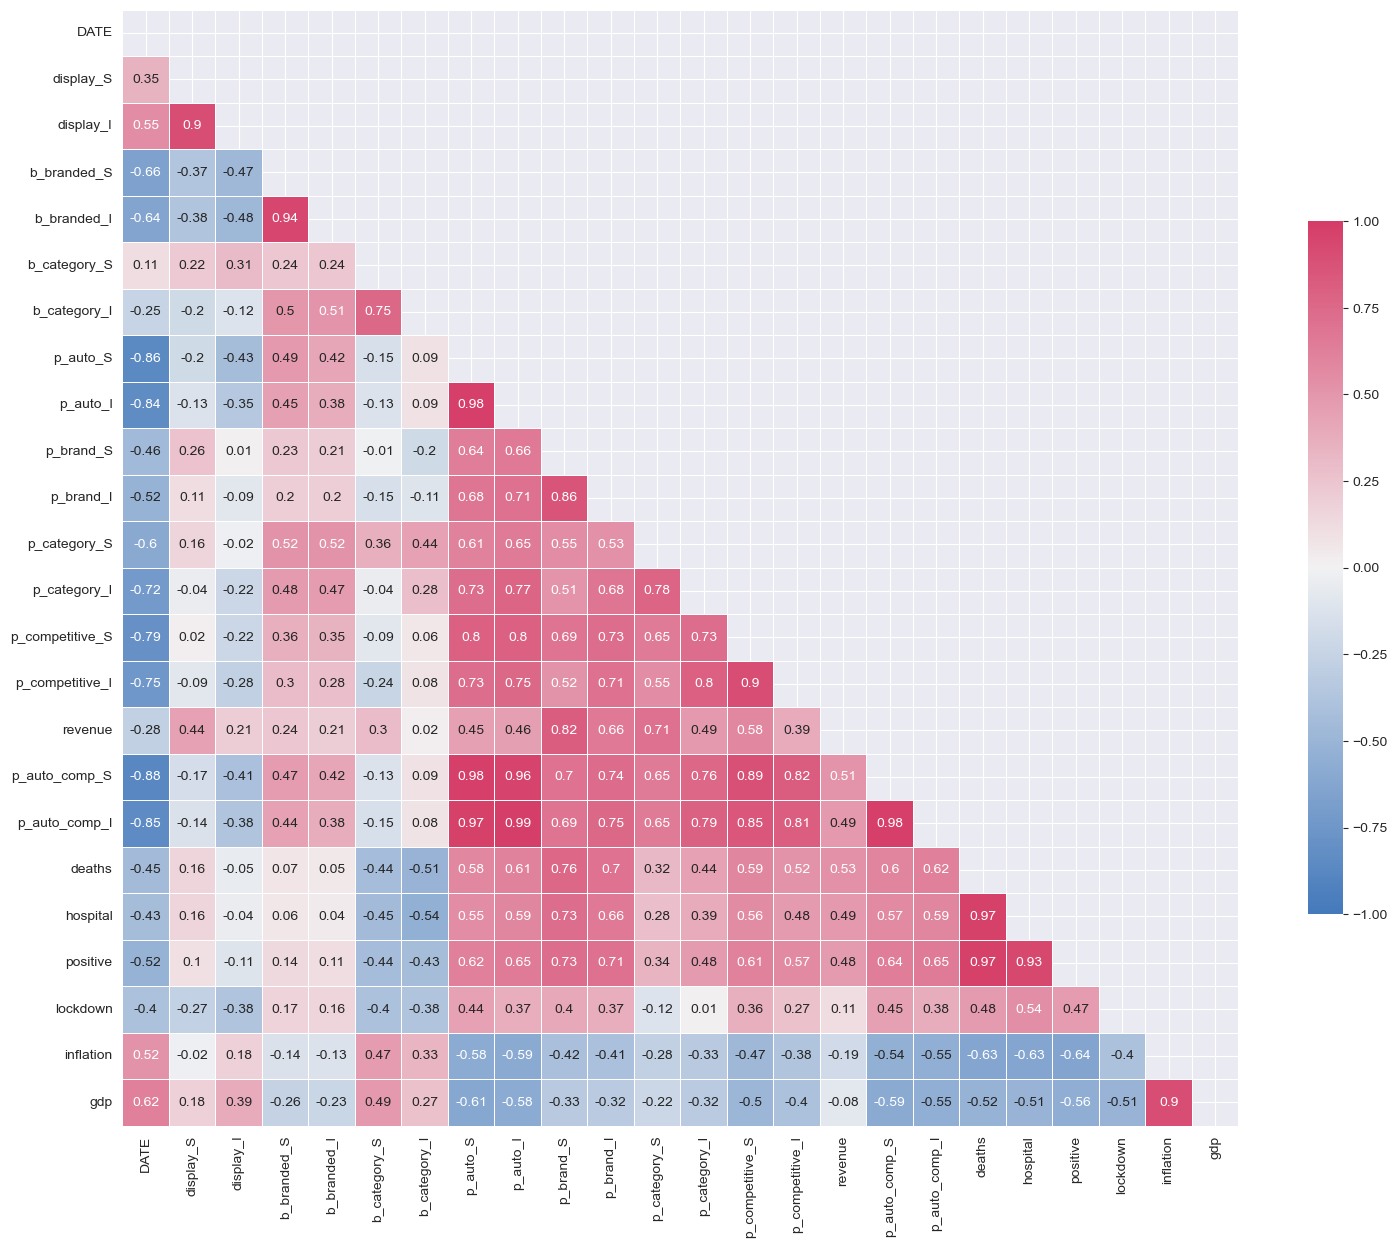

In [20]:
corr = df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

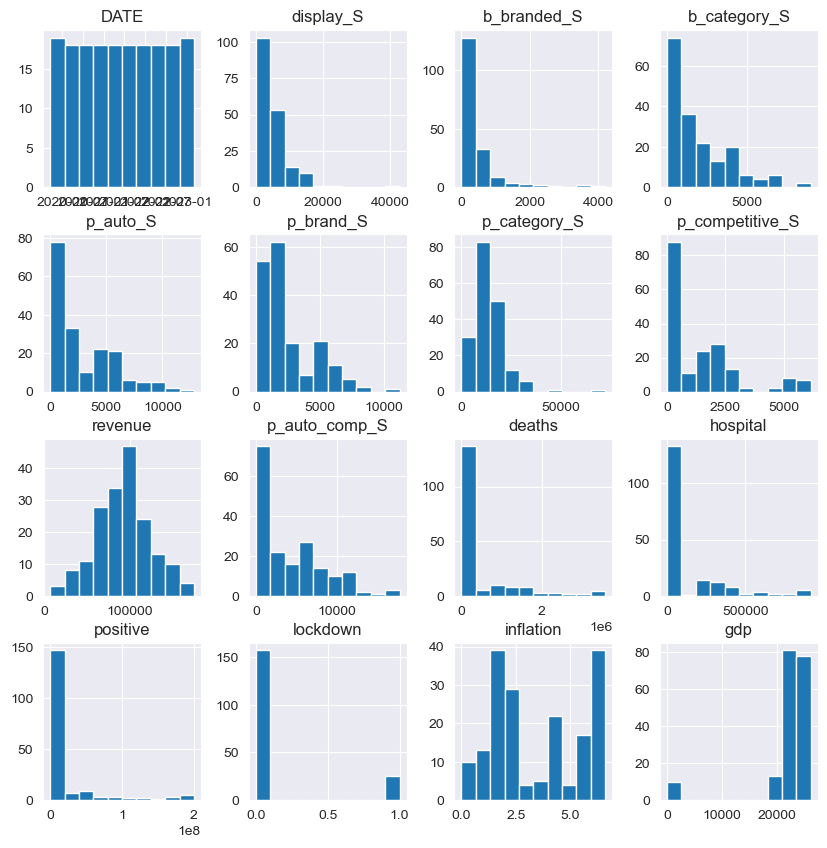

In [21]:
ax = df_spend.hist(grid=True, figsize=(10,10))
ax.set_xlabel("Session Duration (Seconds)")

,DATE,display_S,b_branded_S,b_category_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S,revenue,p_auto_comp_S,deaths,hospital,positive,lockdown,inflation,gdp
count,16.000000,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,-0.233125,0.126250,0.160000,0.06750,0.297500,0.393125,0.308125,0.328750,0.381875,0.321875,0.311875,0.301250,0.304375,0.145000,-0.128125,-0.093750
std,0.575114,0.324117,0.394648,0.41013,0.585155,0.468952,0.426446,0.537548,0.352878,0.591340,0.557090,0.548414,0.566050,0.444267,0.551473,0.555696
min,-0.880000,-0.370000,-0.660000,-0.45000,-0.860000,-0.460000,-0.600000,-0.790000,-0.280000,-0.880000,-0.630000,-0.630000,-0.640000,-0.510000,-0.640000,-0.610000
25%,-0.615000,-0.057500,0.010000,-0.21250,-0.162500,0.170000,0.090000,-0.007500,0.207500,-0.140000,-0.057500,-0.062500,-0.035000,-0.302500,-0.550000,-0.512500
50%,-0.440000,0.160000,0.200000,0.05000,0.520000,0.595000,0.350000,0.570000,0.465000,0.540000,0.505000,0.515000,0.475000,0.265000,-0.340000,-0.295000
75%,0.170000,0.230000,0.387500,0.31500,0.625000,0.730000,0.620000,0.660000,0.542500,0.662500,0.640000,0.610000,0.662500,0.455000,0.102500,0.257500
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


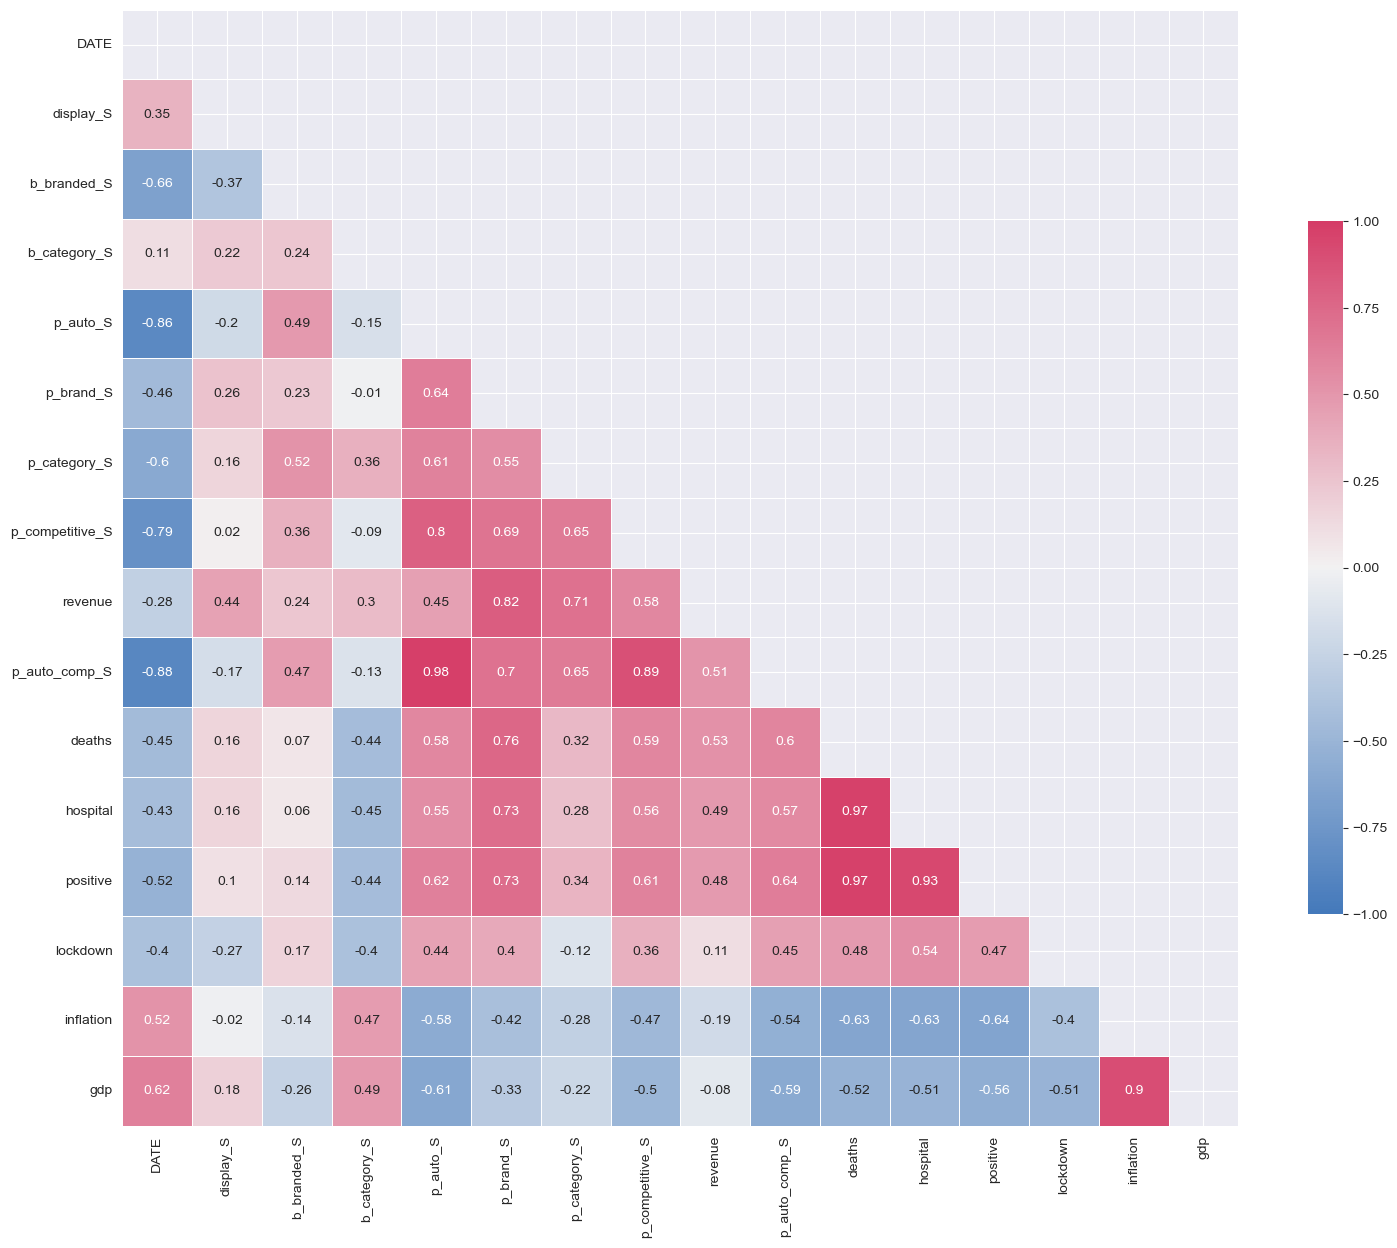

In [22]:
corr = df_spend.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

,DATE,revenue,deaths,hospital,positive,lockdown,inflation,gdp
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.007500,0.257500,0.293750,0.295000,0.266250,0.161250,-0.008750,0.042500
std,0.603626,0.439797,0.714402,0.705408,0.725415,0.551244,0.705011,0.685623
min,-0.520000,-0.280000,-0.630000,-0.630000,-0.640000,-0.510000,-0.640000,-0.560000
25%,-0.435000,-0.107500,-0.467500,-0.450000,-0.530000,-0.400000,-0.630000,-0.512500
50%,-0.340000,0.295000,0.505000,0.515000,0.475000,0.290000,-0.295000,-0.295000
75%,0.545000,0.500000,0.970000,0.940000,0.940000,0.495000,0.615000,0.690000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


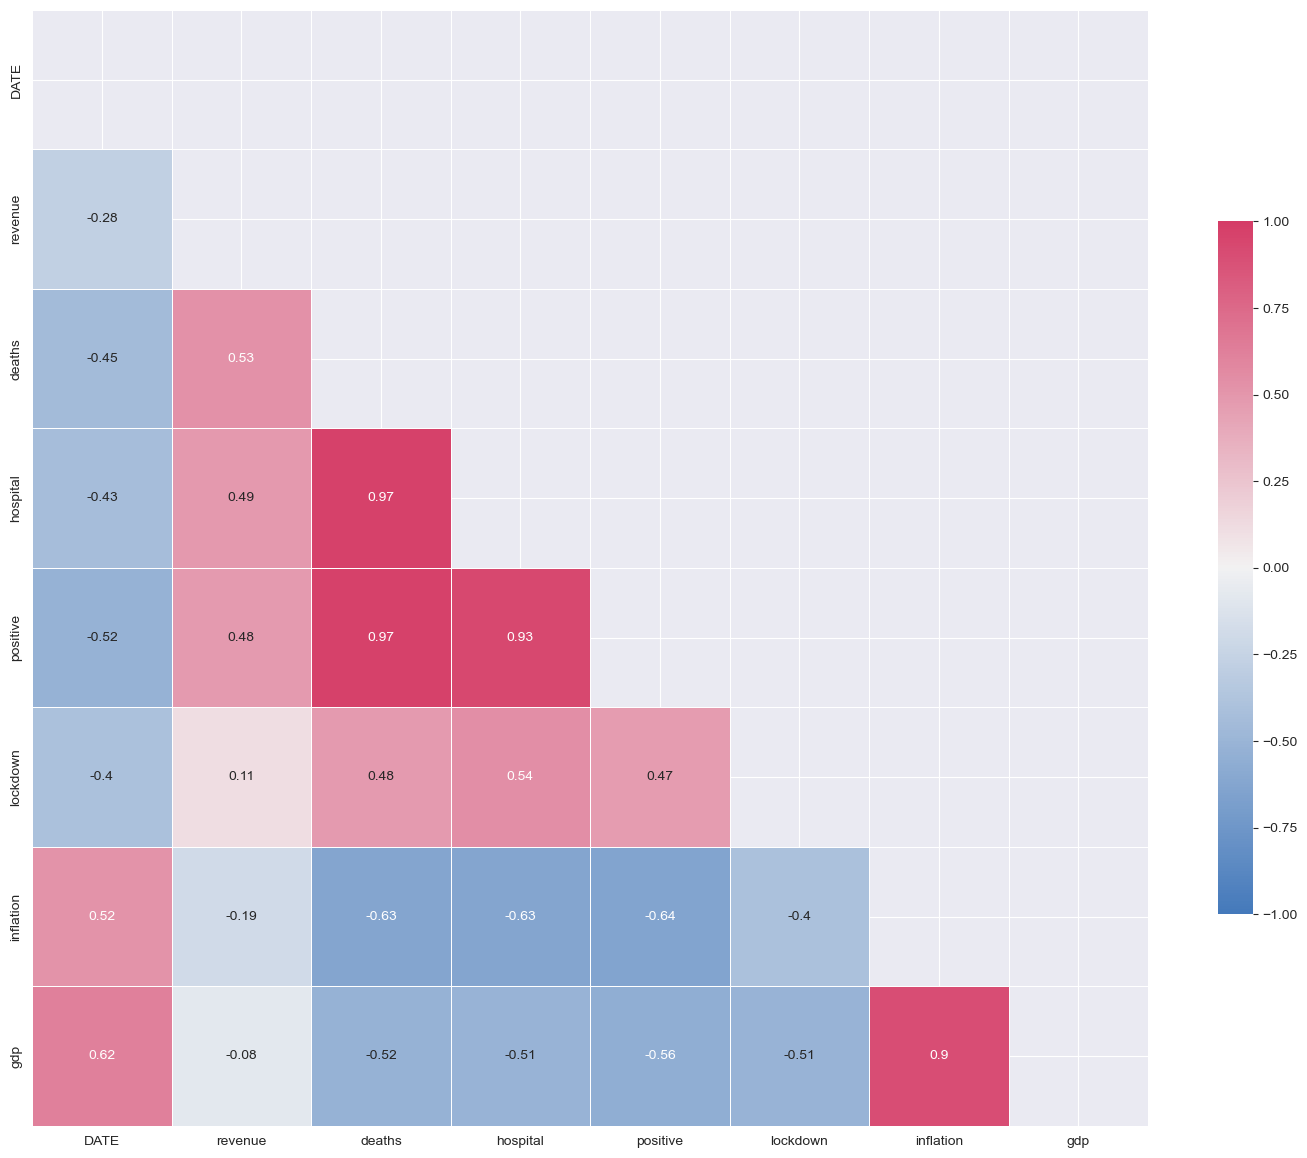

In [23]:
corr = df_context.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()